set color cycle ...
register goldfish colorbar as 'gfcmap' ...
update rc params to default ...


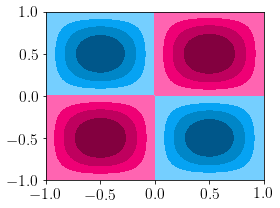

In [89]:
from pypde import *
import matplotlib.pyplot as plt
initplot()

shape = (120,120)

# Create velocity fields

xbase = Base(shape[0],"CD")
ybase = Base(shape[1],"CD")

ux = Field([xbase,ybase])
uz = Field([xbase,ybase])

xbase = Base(shape[0],"CH")
ybase = Base(shape[1],"CH")
deriv = Field([xbase,ybase])

x,y = ux.x, ux.y
xx,yy = np.meshgrid(x,y,indexing="ij")

# Set velocity fields
m,n = 1,1
ux.v =  2*np.cos(0.5*m*np.pi*xx)*np.sin(1.0*n*np.pi*yy)
uz.v = -2*np.sin(1.0*m*np.pi*xx)*np.cos(0.5*n*np.pi*yy)


ux.v =  2*np.sin(1.0*m*np.pi*xx)*np.sin(1.0*n*np.pi*yy)
uz.v = -2*np.sin(1.0*m*np.pi*xx)*np.sin(1.0*n*np.pi*yy)

ux.forward()
uz.forward()

plt.contourf(xx,yy,ux.v)
plt.show()

## Divergence of u
f = $\nabla \cdot u$

Divergence: 8.33e+00


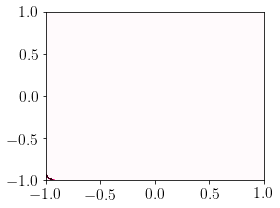

In [90]:
dudx = grad(ux,deriv=(1,0),return_field=False)
dudz = grad(uz,deriv=(0,1),return_field=False)
#dudx = deriv.backward(dudx)
#dudz = deriv.backward(dudz)

f = dudx + dudz
print("Divergence: {:4.2e}".format(np.linalg.norm(f)))

levels = np.linspace(-0.0000001,0.0000001,100)
plt.contourf(xx,yy,dudx,levels=levels)
plt.show()

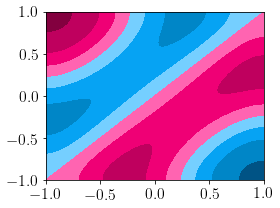

In [91]:
class Poisson(Integrator):
    CONFIG={
        "shape": (50,50),
        "bases": ("CN","CN"),
        "ndim": 2,
        "singular": True,
    }
    def __init__(self,**kwargs):
        Integrator.__init__(self)
        self.__dict__.update(**self.CONFIG)
        self.__dict__.update(**kwargs)
        
        # Field
        xbase = Base(self.shape[0],self.bases[0])
        ybase = Base(self.shape[1],self.bases[1])
        self.field = Field( [xbase,ybase])

        # Solver
        self.setup_solver()
        
        # Space for derivatives
        xbase = Base(self.shape[0],"CH")
        ybase = Base(self.shape[1],"CH")
        self.deriv_field = Field( [xbase,ybase] )
        
    def setup_solver(self):
        from pypde.templates.poisson import solverplan_poisson2d
        self.solver = solverplan_poisson2d(self.field.xs,
            singular=self.singular)
        
    def update(self,fhat):
        rhs  = self.solver.solve_rhs(fhat)
        #print(rhs)
        self.field.vhat[:] = self.solver.solve_lhs(rhs)
        #print(self.field.vhat)
        if self.singular:
            self.field.vhat[0,0] = 0
        #print(self.field.vhat)
        #print(self.field.vhat)
        
P  = Poisson(shape=shape)
P.update(f)

P.field.backward()

plt.contourf(xx,yy,P.field.v)
plt.show()

#P.field.vhat

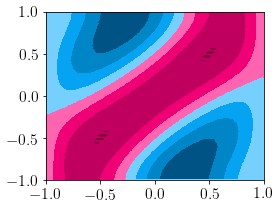

In [104]:
xx,yy = np.meshgrid(P.field.x[:],P.field.y[:],indexing="ij" )

dpdx = grad(P.field,deriv=(1,0),return_field=False)
dpdz = grad(P.field,deriv=(0,1),return_field=False)

d2pdx = grad(P.field,deriv=(2,0),return_field=False)
d2pdz = grad(P.field,deriv=(0,2),return_field=False)
#dpdx = P.deriv_field.backward(dpdx)

#plt.contourf(xx,yy,dpdx)
#plt.show()

def cheby_to_u(vhat,u_field):
    vhat = u_field.xs[0].from_chebyshev(vhat)
    vhat = np.swapaxes(vhat,0,1)
    vhat = u_field.xs[1].from_chebyshev(vhat)
    return np.swapaxes(vhat,0,1)

dpdx2 = cheby_to_galerkin(dpdx,ux)
dpdz2 = cheby_to_galerkin(dpdz,uz)

xbase = Base(shape[0],"CD")
ybase = Base(shape[1],"CD")

dp = Field([xbase,ybase])
dp.vhat = dpdx2
dp.backward()
plt.contourf(xx,yy,dp.v)

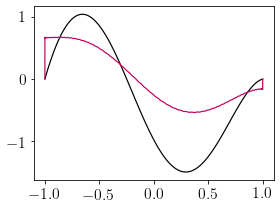

In [102]:
plt.plot(x,dp.v[:,20])

plt.plot(y,dp.v[20,:])

In [93]:
f2 = d2pdx + d2pdz
np.linalg.norm(f-f2)

3.228246985082156e-10

Divergence: 3.23e-10


1.5276446346965193

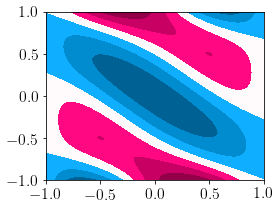

In [94]:
uxold = grad(ux,deriv=(0,0),return_field=True)
uzold = grad(uz,deriv=(0,0),return_field=True)

uxold.vhat -= dpdx
uzold.vhat -= dpdz

dudx = grad(uxold,deriv=(1,0),return_field=False)
dudz = grad(uzold,deriv=(0,1),return_field=False)

f = dudx + dudz
print("Divergence: {:4.2e}".format(np.linalg.norm(f)))

P.deriv_field.vhat = uxold.vhat
P.deriv_field.backward()

plt.contourf(xx,yy,P.deriv_field.v)
P.deriv_field.v.max()

Divergence: 4.91e-02


1.5258361662006918

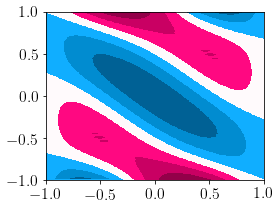

In [95]:
uxnew = ux
uznew = uz

uxnew.vhat -= cheby_to_galerkin(dpdx,uxnew)
uznew.vhat -= cheby_to_galerkin(dpdz,uznew)

dudx = grad(uxnew,deriv=(1,0),return_field=False)
dudz = grad(uznew,deriv=(0,1),return_field=False)

f = dudx[5:-5,5:-5] + dudz[5:-5,5:-5]
print("Divergence: {:4.2e}".format(np.linalg.norm(f)))

#P.deriv_field.vhat = uxnew.vhat
#P.deriv_field.backward()
uxnew.backward()
plt.contourf(xx,yy,uxnew.v)
uxnew.v.max()



In [97]:
f.argmax()
amax = np.unravel_index(f.argmax(), f.shape)
f[amax]

0.005903865337189947

In [87]:
ux.vhat = uxnew
uz.vhat = uznew

dudx = grad(ux,deriv=(1,0),return_field=False)
dudz = grad(uz,deriv=(0,1),return_field=False)

#dudx = deriv.backward(dudx)
#dudz = deriv.backward(dudz)
f = dudx + dudz

AssertionError: 120 118

In [88]:
print("Divergence: {:4.2e}".format(np.linalg.norm(f)))

Divergence: 1.03e+00


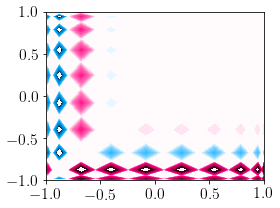

In [91]:
levels = np.linspace(-0.1,0.1,100)
plt.contourf(xx,yy,f,levels=levels)

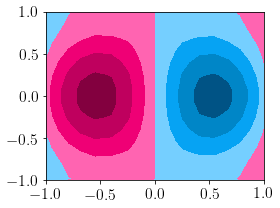

In [113]:
uz.backward()

plt.contourf(xx,yy,uz.v)
plt.show()

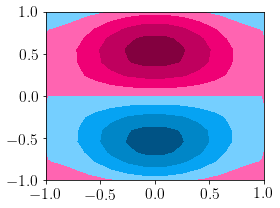

In [114]:
ux.backward()

plt.contourf(xx,yy,ux.v)
plt.show()

In [149]:
shape = (6,6)

# Create velocity fields

xbase = Base(shape[0],"CH")
ybase = Base(shape[1],"CH")
CH = Field([xbase,ybase])
xbase = Base(shape[0],"CD")
ybase = Base(shape[1],"CD")
CD = Field([xbase,ybase])

x,y = CH.x, CH.y
xx,yy = np.meshgrid(x,y,indexing="ij")

CH.v = np.sin(np.pi*xx)*np.sin(np.pi*yy)
CD.v = np.sin(np.pi*xx)*np.sin(np.pi*yy)
CH.forward()
CD.forward()

In [150]:
CH.vhat

array([[-6.16297582e-34, -8.48134921e-19,  6.16297582e-34,
        -5.81320323e-18,  0.00000000e+00,  6.66133815e-18],
       [-5.55111512e-18,  3.24301597e-01, -2.22044605e-17,
        -3.83687782e-01,  0.00000000e+00,  5.93861849e-02],
       [ 0.00000000e+00,  2.53495177e-17,  2.46519033e-33,
        -3.42313019e-17,  0.00000000e+00,  8.88178420e-18],
       [-1.11022302e-17, -3.83687782e-01, -4.44089210e-17,
         4.53948779e-01, -2.22044605e-17, -7.02609971e-02],
       [ 0.00000000e+00, -1.97215226e-33,  1.36845553e-49,
        -1.97215226e-33, -1.36845553e-49, -9.86076132e-34],
       [ 1.38777878e-18,  5.93861849e-02,  1.11022302e-17,
        -7.02609971e-02, -5.55111512e-18,  1.08748122e-02]])

In [151]:
CD.vhat

array([[-2.13821177e-50, -9.01526253e-18, -3.08148791e-34,
        -1.48029737e-18],
       [-3.70074342e-18,  3.24301597e-01, -1.85037171e-18,
        -5.93861849e-02],
       [-2.05432527e-34,  8.16712761e-18,  5.13581319e-34,
        -5.18104078e-18],
       [ 9.25185854e-19, -5.93861849e-02, -7.86407976e-18,
         1.08748122e-02]])

In [152]:
cheby_to_galerkin(CH.vhat,CD)

array([[-1.36955018e-34, -9.01526253e-18, -2.73910037e-34,
        -1.48029737e-18],
       [-2.15876699e-18,  3.24301597e-01, -7.55568447e-18,
        -5.93861849e-02],
       [-4.79342564e-34,  8.16712761e-18,  2.73910037e-34,
        -5.18104078e-18],
       [ 6.78469626e-18, -5.93861849e-02, -9.56025382e-18,
         1.08748122e-02]])

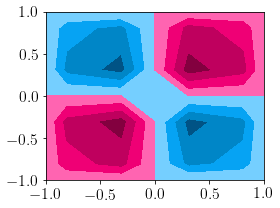

In [143]:
plt.contourf(xx,yy,CH.v)
plt.show()